In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 📥 Load your historical asset data (CSV file)
file_path = '/content/Expanded_AssetData_Equity_Bonds_Currency.csv'  # <- Update this path
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
# 🎯 Define target tickers and constraints
target_tickers = ['AAPL', 'MSFT', 'JPM', 'GOOG', 'KO', 'GLD', 'TLT', 'BTCUSD', 'USDINR', 'SPY']
max_allocs = {'BTCUSD': 0.10, 'USDINR': 0.05}
n_assets = len(target_tickers)

In [ ]:
# 🧼 Clean and prepare returns matrix
df = df[df['Ticker'].isin(target_tickers)]
pivot_df = df.pivot(index='Date', columns='Ticker', values='Close').sort_index().dropna()
returns_df = pivot_df.pct_change().dropna()

In [ ]:
# 📊 Mean and Covariance
mean_returns = returns_df.mean()
cov_matrix = returns_df.cov()
risk_free_rate_daily = 0.005 / 252

In [ ]:
# 🎯 Sharpe Ratio function
def calculate_sharpe(weights, mean_returns, cov_matrix, rf=risk_free_rate_daily):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return (portfolio_return - rf) / portfolio_std if portfolio_std != 0 else 0

In [ ]:
# 🧬 Generate random population with constraints
def generate_population(n_portfolios, n_assets, max_allocs):
    population = []
    for _ in range(n_portfolios):
        weights = np.random.rand(n_assets)
        weights /= weights.sum()

        for asset, limit in max_allocs.items():
            idx = target_tickers.index(asset)
            if weights[idx] > limit:
                excess = weights[idx] - limit
                weights[idx] = limit
                redistribute_idx = [i for i in range(len(weights)) if i != idx]
                redistribute = weights[redistribute_idx]
                redistribute += excess * (redistribute / redistribute.sum())
                for i, j in enumerate(redistribute_idx):
                    weights[j] = redistribute[i]
        population.append(weights / np.sum(weights))
    return np.array(population)

In [ ]:
# 🔧 EA Config
n_generations = 50
population_size = 100
elite_size = 20
mutation_rate = 0.1

In [ ]:
# ⚙️ Normalize + enforce constraints
def normalize_with_constraints(weights):
    weights = np.maximum(weights, 0)
    weights /= weights.sum()
    for asset, max_val in max_allocs.items():
        idx = target_tickers.index(asset)
        if weights[idx] > max_val:
            excess = weights[idx] - max_val
            weights[idx] = max_val
            redistribute_idx = [i for i in range(len(weights)) if i != idx]
            redistribute = weights[redistribute_idx]
            redistribute += excess * (redistribute / redistribute.sum())
            for i, j in enumerate(redistribute_idx):
                weights[j] = redistribute[i]
    return weights / np.sum(weights)


In [ ]:
# 🔀 Crossover (uniform)
def crossover(p1, p2):
    mask = np.random.randint(0, 2, size=len(p1)).astype(bool)
    return np.where(mask, p1, p2)


In [ ]:
# 🎲 Mutation
def mutate(weights, rate=0.1):
    for i in range(len(weights)):
        if np.random.rand() < rate:
            weights[i] += np.random.normal(0, 0.05)
    return weights

In [ ]:
# 🧪 EA Loop
initial_population = generate_population(population_size, n_assets, max_allocs)
current_population = initial_population.copy()
best_sharpes = []
avg_sharpes = []

for gen in range(n_generations):
    sharpe_scores = [calculate_sharpe(w, mean_returns, cov_matrix) for w in current_population]
    best_sharpes.append(np.max(sharpe_scores))
    avg_sharpes.append(np.mean(sharpe_scores))

    elite_indices = np.argsort(sharpe_scores)[-elite_size:]
    elites = current_population[elite_indices]
    new_population = elites.tolist()

    while len(new_population) < population_size:
        parent1, parent2 = elites[np.random.randint(0, elite_size)], elites[np.random.randint(0, elite_size)]
        child = crossover(parent1, parent2)
        child = mutate(child, mutation_rate)
        child = normalize_with_constraints(child)
        new_population.append(child)

    current_population = np.array(new_population)










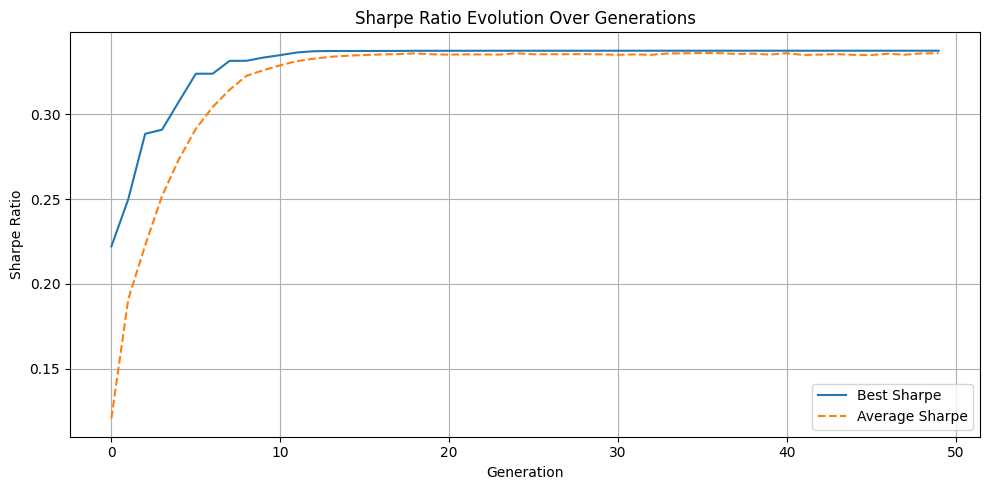

In [ ]:
# 📈 Plot Evolution of Sharpe Ratio
plt.figure(figsize=(10, 5))
plt.plot(best_sharpes, label='Best Sharpe')
plt.plot(avg_sharpes, label='Average Sharpe', linestyle='--')
plt.title('Sharpe Ratio Evolution Over Generations')
plt.xlabel('Generation')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 🏆 Best Portfolio Weights (Final Generation)
final_scores = [calculate_sharpe(w, mean_returns, cov_matrix) for w in current_population]
best_portfolio = current_population[np.argmax(final_scores)]


In [ ]:
# 🔍 View weights
best_df = pd.DataFrame({
    'Asset': target_tickers,
    'Weight': best_portfolio
})
best_df['Weight'] = best_df['Weight'].round(4)
print("🔝 Best Portfolio (Sharpe Ratio = {:.4f}):".format(np.max(final_scores)))
print(best_df)


🔝 Best Portfolio (Sharpe Ratio = 0.3376):
    Asset  Weight
0    AAPL  0.1158
1    MSFT  0.1302
2     JPM  0.0146
3    GOOG  0.1016
4      KO  0.5377
5     GLD  0.0000
6     TLT  0.0000
7  BTCUSD  0.1000
8  USDINR  0.0000
9     SPY  0.0000
